**--- Compare 31-day running mean and lowpass filter spatially across CONUS --**

In [106]:
%matplotlib inline

import xarray as xr
import numpy as np
import os as os
import matplotlib.pyplot as plt
from matplotlib import cm
from cartopy import config
import cartopy.crs as ccrs
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import pandas as pd
import itertools
import datetime 
import toolz
from datetime import date
from pathlib import Path, PurePath

import sys

import dask.distributed as dd
import dask_kubernetes as dk
import dask
import rhg_compute_tools.kubernetes as rhgk

In [2]:
client, cluster = rhgk.get_standard_cluster()
cluster.scale(10)

In [3]:
client

Client Scheduler: gateway://traefik-impactlab-hub-dask-gateway.impactlab-hub:80/impactlab-hub.d7e957b979fd4e4a87588e2ff1494d8f Dashboard: /services/dask-gateway/clusters/impactlab-hub.d7e957b979fd4e4a87588e2ff1494d8f/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [152]:
cluster.close()

In [4]:
# create list of start and end years for rolling mean climo decade calculations

start_years = [1980,1990,2000,2010]
end_years = [1989,1999,2009,2018]

yr_index = 0

In [5]:
# Climatology start times

start_time_climo = ["1980-01-01","1990-01-01","2000-01-01","2010-01-01"]
end_time_climo = ["1989-12-31","1999-12-31","2009-12-31","2018-12-31"]

thirtyyr_period_1980_2009 = ["1980-01-01","2009-12-31"]
thirtyyr_period_1989_2018 = ["1989-01-01","2018-12-31"]

In [6]:
# Per decade analysis
filenames = []

yrs = [*range(start_years[0],end_years[3]+1,1)] 
    
for num_yrs in range(len(yrs)):
    filename = '/gcs/impactlab-data/climate/source_data/ERA-5/day/tas/v1.0/tas_daily_{}-{}.nc'.format(yrs[num_yrs], yrs[num_yrs])
    filenames.append(filename)

In [7]:
era5_tas = xr.open_mfdataset(filenames, 
                               concat_dim='time', combine='by_coords')
print('Loading ERA5 files...')

Loading ERA5 files...


In [8]:
# Pull out leap days
tas_all = era5_tas['tas']

tas_noleap_all = tas_all.where(~((tas_all.time.dt.month == 2) & (tas_all.time.dt.day == 29)), drop=True)

# Change dayofyear to remove day 366 (leap day index)
tas_noleap_all = tas_noleap_all.assign_coords(dayofyear=xr.DataArray(np.array([np.arange(1,366)]*len(yrs)).flatten(),
                                                dims=('time'),
                                                coords={'time':tas_noleap_all.time}))
# tas_noleap_all

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [9]:
tas_noleap_all

<xarray.DataArray 'tas' (time: 14235, latitude: 721, longitude: 1440)>
dask.array<where, shape=(14235, 721, 1440), dtype=float32, chunksize=(365, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2018-12-31
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365
Attributes:
    author:   Diana Gergel
    contact:  dgergel@rhg.com
    project:  historical-climate-data-diagnostics
    source:   era5_hourly_reanalysis_single_levels_sa from Pangeo Datastore, ...
    method:   mean of tas
    units:    K

In [111]:
# tas_noleap_all.nbytes / (1024**3)

tas_noleap_conus = tas_noleap_all.sel(latitude=slice(50.0, 25.0), longitude=slice(220.0,320.0)) # .persist()
tas_noleap_conus.persist()

<xarray.DataArray 'tas' (time: 14235, latitude: 101, longitude: 401)>
dask.array<getitem, shape=(14235, 101, 401), dtype=float32, chunksize=(365, 101, 401), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 50.0 49.75 49.5 49.25 ... 25.5 25.25 25.0
  * longitude  (longitude) float32 220.0 220.2 220.5 220.8 ... 319.5 319.8 320.0
  * time       (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2018-12-31
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365
Attributes:
    author:   Diana Gergel
    contact:  dgergel@rhg.com
    project:  historical-climate-data-diagnostics
    source:   era5_hourly_reanalysis_single_levels_sa from Pangeo Datastore, ...
    method:   mean of tas
    units:    K

In [14]:
# Loop through decade based climatology calculation for all grid points

#perdecade_climo = [[] for i in range(0,len(start_years))]

#for yr_index in range(0,len(start_years)):
    
    # 'Lazy' Calculate climatology 
#    singleclimo_mean = tas_noleap_conus.sel(time=slice(start_time_climo[yr_index], end_time_climo[yr_index])).groupby("dayofyear").mean().persist()
#    climo_withcoords = singleclimo_mean.copy(deep=True, data=singleclimo_mean)
#    perdecade_climo[yr_index].append(climo_withcoords)
    
    

In [112]:
# Calculation of 1989-1999 for 30-yr period of 1989-2018

singleclimo_80s = tas_noleap_conus.sel(time=slice(start_time_climo[0], end_time_climo[0])).groupby("dayofyear").mean().persist()
singleclimo_90s = tas_noleap_conus.sel(time=slice(start_time_climo[1], end_time_climo[1])).groupby("dayofyear").mean().persist()
singleclimo_00s = tas_noleap_conus.sel(time=slice(start_time_climo[2], end_time_climo[2])).groupby("dayofyear").mean().persist()
singleclimo_10s = tas_noleap_conus.sel(time=slice(start_time_climo[3], end_time_climo[3])).groupby("dayofyear").mean().persist()

singleclimo_1989_1999 = tas_noleap_conus.sel(time=slice('1989-01-01', '1999-12-31')).groupby("dayofyear").mean().persist()

In [113]:
singleclimo_1989_1999

<xarray.DataArray 'tas' (dayofyear: 365, latitude: 101, longitude: 401)>
dask.array<stack, shape=(365, 101, 401), dtype=float32, chunksize=(1, 101, 401), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 50.0 49.75 49.5 49.25 ... 25.5 25.25 25.0
  * longitude  (longitude) float32 220.0 220.2 220.5 220.8 ... 319.5 319.8 320.0
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365

In [114]:
# Create two 30-yr periods -- still xarray.DataArray

climo_1980_2009 = (singleclimo_80s + singleclimo_90s + singleclimo_00s) / 3.0
climo_1989_2018 = (singleclimo_1989_1999 + singleclimo_00s + singleclimo_10s) / 3.0

In [115]:
climo_1980_2009.sel(dayofyear=(index+1)).mean(dim='dayofyear')

<xarray.DataArray 'tas' (latitude: 101, longitude: 401)>
dask.array<mean_agg-aggregate, shape=(101, 401), dtype=float32, chunksize=(101, 401), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 50.0 49.75 49.5 49.25 ... 25.5 25.25 25.0
  * longitude  (longitude) float32 220.0 220.2 220.5 220.8 ... 319.5 319.8 320.0

In [116]:
# For each 30-yr period calculate 31-day running mean and lowpass filter

climo_31runningmean_1980_2009 = []
climo_31runningmean_1989_2018 = []

# 31-day running mean
for i_day in range(0,365):

    if i_day < 15:
        index1 = np.arange(365-(15-i_day),365)
        index2 = np.arange(0,i_day+16)
        index = np.concatenate((index1,index2))

    elif i_day > 348:
        index1 = np.arange(i_day-15,365)
        index2 = np.arange(0,16-(365-i_day))
        index = np.concatenate((index1,index2))

    else:
        index = np.arange(i_day-15,i_day+16)
            
    # per decade year climo, 31-day index & average then append to per decade date
    days31 = climo_1980_2009.sel(dayofyear=(index+1)).mean(dim='dayofyear').persist()
    climo_31runningmean_1980_2009.append(days31)
    
    
    days31_2 = climo_1989_2018.sel(dayofyear=(index+1)).mean(dim='dayofyear').persist()
    climo_31runningmean_1989_2018.append(days31_2)


In [117]:
# convert to dataarray
climo_31runningmean_1980_2009 = xr.DataArray(climo_31runningmean_1980_2009)
climo_31runningmean_1989_2018 = xr.DataArray(climo_31runningmean_1989_2018)

# copy coordinates to new array using existing array
climo31_1980_2009_withcoords = climo_1980_2009.copy(deep=True, data=climo_31runningmean_1980_2009)
climo31_1980_2009_withcoords

climo31_1989_2018_withcoords = climo_1989_2018.copy(deep=True, data=climo_31runningmean_1989_2018)

In [118]:
# For each 30-yr period calculate lowpass filter
import scipy.signal as signal

# First, design the Buterworth filter
N  = 2    # Filter order
Wn = (1/31)   # Cutoff frequency --> time step (daily) / desired filter length (days)
B, A = signal.butter(N, Wn, output='ba')

# low pass filter
climo_lowpass_1980_2009 = signal.filtfilt(B,A, climo_1980_2009, padtype='constant', padlen=60, method='pad')
climo_lowpass_1989_2018 = signal.filtfilt(B,A, climo_1989_2018, padtype='constant', padlen=60, method='pad')

In [119]:
# convert to dataarray
climo_lowpass_1980_2009 = xr.DataArray(climo_lowpass_1980_2009)
climo_lowpass_1989_2018 = xr.DataArray(climo_lowpass_1989_2018)

# copy coordinates to new array from using climo array with coordinates
climo_lp_1980_2009_withcoords = climo_1980_2009.copy(deep=True, data=climo_lowpass_1980_2009)
climo_lp_1989_2018_withcoords = climo_1989_2018.copy(deep=True, data=climo_lowpass_1989_2018)

#np.shape(climo_lowpass_1980_2009)

In [120]:
# Seasonal means of climatologies

# low pass filter 
# 1980-2009
MAM_lp_1980_2009 = climo_lp_1980_2009_withcoords.sel(dayofyear=slice(60,151)).mean('dayofyear')
JJA_lp_1980_2009 = climo_lp_1980_2009_withcoords.sel(dayofyear=slice(152,243)).mean('dayofyear')
SON_lp_1980_2009 = climo_lp_1980_2009_withcoords.sel(dayofyear=slice(244,334)).mean('dayofyear')

D_lp_1980_2009   = climo_lp_1980_2009_withcoords.sel(dayofyear=slice(335,365)) 
JF_lp_1980_2009  = climo_lp_1980_2009_withcoords.sel(dayofyear=slice(0,59))

DJF_lp_1980_2009 = xr.concat((D_lp_1980_2009, JF_lp_1980_2009), dim='dayofyear')
DJF_lp_1980_2009 = DJF_lp_1980_2009.mean('dayofyear') 

# 1989-2018
MAM_lp_1989_2018 = climo_lp_1989_2018_withcoords.sel(dayofyear=slice(60,151)).mean('dayofyear')
JJA_lp_1989_2018 = climo_lp_1989_2018_withcoords.sel(dayofyear=slice(152,243)).mean('dayofyear')
SON_lp_1989_2018 = climo_lp_1989_2018_withcoords.sel(dayofyear=slice(244,334)).mean('dayofyear')

D_lp_1989_2018   = climo_lp_1989_2018_withcoords.sel(dayofyear=slice(335,365)) 
JF_lp_1989_2018  = climo_lp_1989_2018_withcoords.sel(dayofyear=slice(0,59))

DJF_lp_1989_2018 = xr.concat((D_lp_1989_2018, JF_lp_1989_2018), dim='dayofyear')
DJF_lp_1989_2018 = DJF_lp_1989_2018.mean('dayofyear') 

# 31-day running mean climo
# 1980-2009
MAM_31_1980_2009 = climo31_1980_2009_withcoords.sel(dayofyear=slice(60,151)).mean('dayofyear')
JJA_31_1980_2009 = climo31_1980_2009_withcoords.sel(dayofyear=slice(152,243)).mean('dayofyear')
SON_31_1980_2009 = climo31_1980_2009_withcoords.sel(dayofyear=slice(244,334)).mean('dayofyear')

D_31_1980_2009   = climo31_1980_2009_withcoords.sel(dayofyear=slice(335,365)) 
JF_31_1980_2009  = climo31_1980_2009_withcoords.sel(dayofyear=slice(0,59))

DJF_31_1980_2009 = xr.concat((D_31_1980_2009, JF_31_1980_2009), dim='dayofyear')
DJF_31_1980_2009 = DJF_31_1980_2009.mean('dayofyear') 

# 1989-2018
MAM_31_1989_2018 = climo31_1989_2018_withcoords.sel(dayofyear=slice(60,151)).mean('dayofyear')
JJA_31_1989_2018 = climo31_1989_2018_withcoords.sel(dayofyear=slice(152,243)).mean('dayofyear')
SON_31_1989_2018 = climo31_1989_2018_withcoords.sel(dayofyear=slice(244,334)).mean('dayofyear')

D_31_1989_2018   = climo31_1989_2018_withcoords.sel(dayofyear=slice(335,365)) 
JF_31_1989_2018  = climo31_1989_2018_withcoords.sel(dayofyear=slice(0,59))

DJF_31_1989_2018 = xr.concat((D_31_1989_2018, JF_31_1989_2018), dim='dayofyear')
DJF_31_1989_2018 = DJF_31_1989_2018.mean('dayofyear') 

In [142]:
JJA_lp_1980_2009.max()

<xarray.DataArray 'tas' ()>
array(303.11178896)

Text(0.5, 1.0, 'DJF: Lowpass Filter Mean 1980-2009')

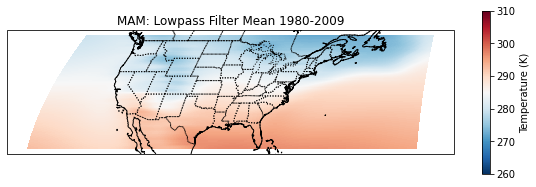

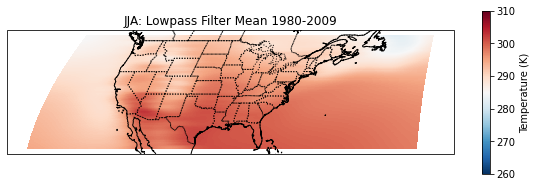

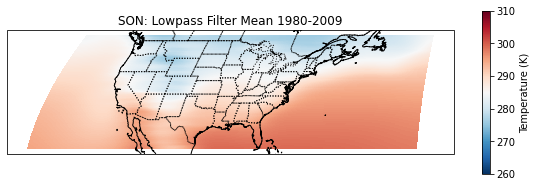

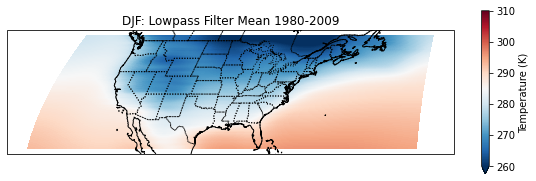

In [147]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=(10, 3))
ax = plt.axes(projection=ccrs.Robinson())
cmap = cm.RdBu_r

MAM_lp_1980_2009.plot(
    ax=ax,
    cmap=cmap,
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": "Temperature (K)"}, vmin=260.0, vmax=310.0)

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle=":")
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.set_title("MAM: Lowpass Filter Mean 1980-2009")

fig = plt.figure(figsize=(10, 3))
ax = plt.axes(projection=ccrs.Robinson())
cmap = cm.RdBu_r

JJA_lp_1980_2009.plot(
    ax=ax,
    cmap=cmap,
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": "Temperature (K)"}, vmin=260.0, vmax=310.0)

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle=":")
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.set_title("JJA: Lowpass Filter Mean 1980-2009")

fig = plt.figure(figsize=(10, 3))
ax = plt.axes(projection=ccrs.Robinson())
cmap = cm.RdBu_r

SON_lp_1980_2009.plot(
    ax=ax,
    cmap=cmap,
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": "Temperature (K)"}, vmin=260.0, vmax=310.0)

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle=":")
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.set_title("SON: Lowpass Filter Mean 1980-2009")

fig = plt.figure(figsize=(10, 3))
ax = plt.axes(projection=ccrs.Robinson())
cmap = cm.RdBu_r

DJF_lp_1980_2009.plot(
    ax=ax,
    cmap=cmap,
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": "Temperature (K)"}, vmin=260.0, vmax=310.0)

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle=":")
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.set_title("DJF: Lowpass Filter Mean 1980-2009")

Text(0.5, 1.0, 'DJF: Lowpass Filter Mean 1989-2018')

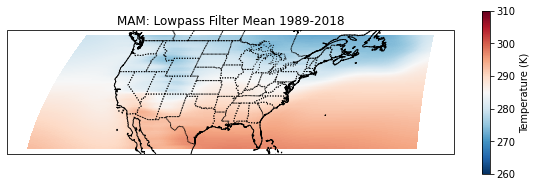

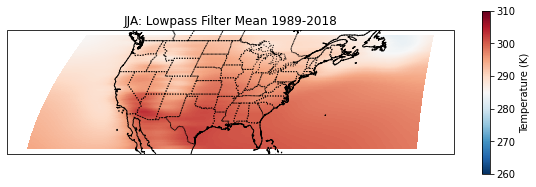

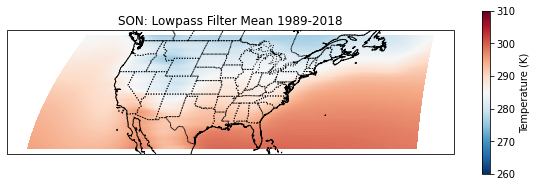

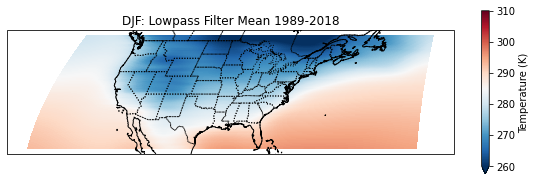

In [146]:
fig = plt.figure(figsize=(10, 3))
ax = plt.axes(projection=ccrs.Robinson())
cmap = cm.RdBu_r

MAM_lp_1989_2018.plot(
    ax=ax,
    cmap=cmap,
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": "Temperature (K)"}, vmin=260.0, vmax=310.0)

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle=":")
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.set_title("MAM: Lowpass Filter Mean 1989-2018")

fig = plt.figure(figsize=(10, 3))
ax = plt.axes(projection=ccrs.Robinson())
cmap = cm.RdBu_r

JJA_lp_1989_2018.plot(
    ax=ax,
    cmap=cmap,
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": "Temperature (K)"}, vmin=260.0, vmax=310.0)

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle=":")
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.set_title("JJA: Lowpass Filter Mean 1989-2018")

fig = plt.figure(figsize=(10, 3))
ax = plt.axes(projection=ccrs.Robinson())
cmap = cm.RdBu_r

SON_lp_1989_2018.plot(
    ax=ax,
    cmap=cmap,
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": "Temperature (K)"}, vmin=260.0, vmax=310.0)

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle=":")
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.set_title("SON: Lowpass Filter Mean 1989-2018")

fig = plt.figure(figsize=(10, 3))
ax = plt.axes(projection=ccrs.Robinson())
cmap = cm.RdBu_r

DJF_lp_1989_2018.plot(
    ax=ax,
    cmap=cmap,
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": "Temperature (K)"}, vmin=260.0, vmax=310.0)

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle=":")
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.set_title("DJF: Lowpass Filter Mean 1989-2018")

Text(0.5, 1.0, 'DJF: 31-day Running Mean 1980-2009')

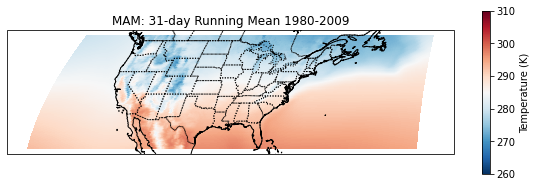

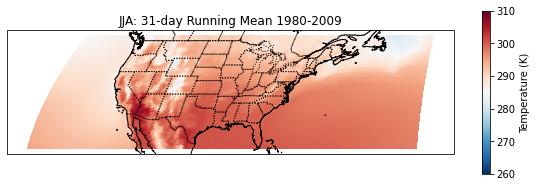

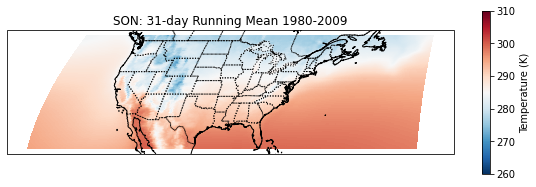

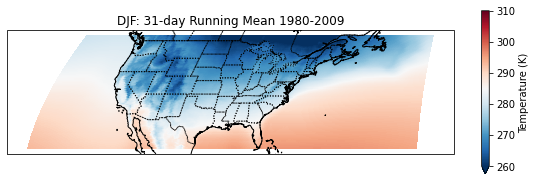

In [149]:
fig = plt.figure(figsize=(10, 3))
ax = plt.axes(projection=ccrs.Robinson())
cmap = cm.RdBu_r

MAM_31_1980_2009.plot(
    ax=ax,
    cmap=cmap,
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": "Temperature (K)"}, vmin=260.0, vmax=310.0)

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle=":")
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.set_title("MAM: 31-day Running Mean 1980-2009")

fig = plt.figure(figsize=(10, 3))
ax = plt.axes(projection=ccrs.Robinson())
cmap = cm.RdBu_r

JJA_31_1980_2009.plot(
    ax=ax,
    cmap=cmap,
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": "Temperature (K)"}, vmin=260.0, vmax=310.0)

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle=":")
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.set_title("JJA: 31-day Running Mean 1980-2009")

fig = plt.figure(figsize=(10, 3))
ax = plt.axes(projection=ccrs.Robinson())
cmap = cm.RdBu_r

SON_31_1980_2009.plot(
    ax=ax,
    cmap=cmap,
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": "Temperature (K)"}, vmin=260.0, vmax=310.0)

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle=":")
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.set_title("SON: 31-day Running Mean 1980-2009")

fig = plt.figure(figsize=(10, 3))
ax = plt.axes(projection=ccrs.Robinson())
cmap = cm.RdBu_r

DJF_31_1980_2009.plot(
    ax=ax,
    cmap=cmap,
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": "Temperature (K)"}, vmin=260.0, vmax=310.0)

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle=":")
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.set_title("DJF: 31-day Running Mean 1980-2009")

Text(0.5, 1.0, 'DJF: 31-day Running Mean 1989-2018')

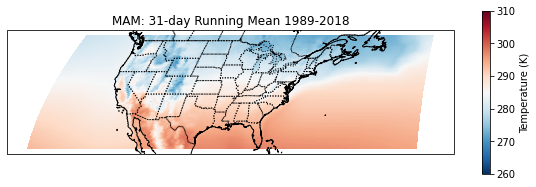

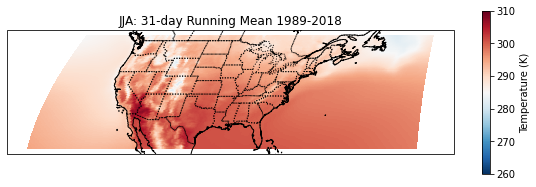

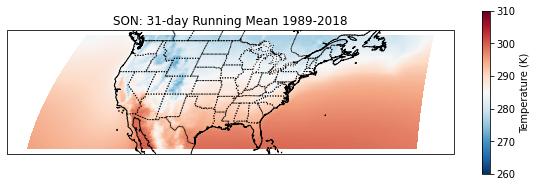

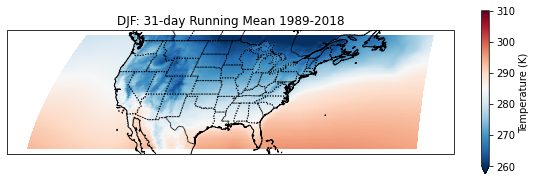

In [148]:
fig = plt.figure(figsize=(10, 3))
ax = plt.axes(projection=ccrs.Robinson())
cmap = cm.RdBu_r

MAM_31_1989_2018.plot(
    ax=ax,
    cmap=cmap,
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": "Temperature (K)"}, vmin=260.0, vmax=310.0)

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle=":")
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.set_title("MAM: 31-day Running Mean 1989-2018")

fig = plt.figure(figsize=(10, 3))
ax = plt.axes(projection=ccrs.Robinson())
cmap = cm.RdBu_r

JJA_31_1989_2018.plot(
    ax=ax,
    cmap=cmap,
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": "Temperature (K)"}, vmin=260.0, vmax=310.0)

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle=":")
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.set_title("JJA: 31-day Running Mean 1989-2018")

fig = plt.figure(figsize=(10, 3))
ax = plt.axes(projection=ccrs.Robinson())
cmap = cm.RdBu_r

SON_31_1989_2018.plot(
    ax=ax,
    cmap=cmap,
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": "Temperature (K)"}, vmin=260.0, vmax=310.0)

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle=":")
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.set_title("SON: 31-day Running Mean 1989-2018")

fig = plt.figure(figsize=(10, 3))
ax = plt.axes(projection=ccrs.Robinson())
cmap = cm.RdBu_r

DJF_31_1989_2018.plot(
    ax=ax,
    cmap=cmap,
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": "Temperature (K)"}, vmin=260.0, vmax=310.0)

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle=":")
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.set_title("DJF: 31-day Running Mean 1989-2018")

In [131]:
# Difference between LP filter and 31-day running mean seasonal mean

MAM_diff_1980_2009 = MAM_lp_1980_2009 - MAM_31_1980_2009
JJA_diff_1980_2009 = JJA_lp_1980_2009 - JJA_31_1980_2009
SON_diff_1980_2009 = SON_lp_1980_2009 - SON_31_1980_2009
DJF_diff_1980_2009 = DJF_lp_1980_2009 - DJF_31_1980_2009

MAM_diff_1989_2018 = MAM_lp_1989_2018 - MAM_31_1989_2018
JJA_diff_1989_2018 = JJA_lp_1989_2018 - JJA_31_1989_2018
SON_diff_1989_2018 = SON_lp_1989_2018 - SON_31_1989_2018
DJF_diff_1989_2018 = DJF_lp_1989_2018 - DJF_31_1989_2018

In [ ]:
# Plot differences between methods for each 30-yr period in (2,4) plot

Text(0.5, 1.0, 'DJF: Difference of Lowpass Filter and 31-day Mean 1980-2009')

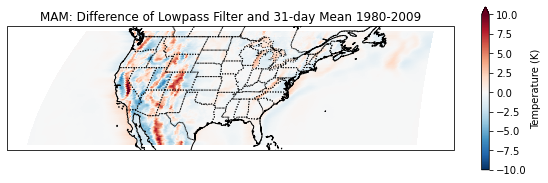

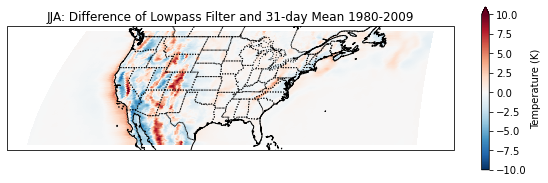

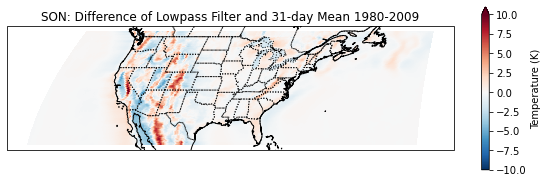

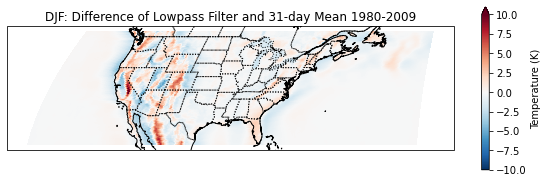

In [150]:
fig = plt.figure(figsize=(10, 3))
ax = plt.axes(projection=ccrs.Robinson())
cmap = cm.RdBu_r

MAM_diff_1980_2009.plot(
    ax=ax,
    cmap=cmap,
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": "Temperature (K)"}, vmin=-10.0, vmax=10.0)

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle=":")
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.set_title("MAM: Difference of Lowpass Filter and 31-day Mean 1980-2009")

fig = plt.figure(figsize=(10, 3))
ax = plt.axes(projection=ccrs.Robinson())
cmap = cm.RdBu_r

JJA_diff_1980_2009.plot(
    ax=ax,
    cmap=cmap,
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": "Temperature (K)"}, vmin=-10.0, vmax=10.0)

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle=":")
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.set_title("JJA: Difference of Lowpass Filter and 31-day Mean 1980-2009")

fig = plt.figure(figsize=(10, 3))
ax = plt.axes(projection=ccrs.Robinson())
cmap = cm.RdBu_r

SON_diff_1980_2009.plot(
    ax=ax,
    cmap=cmap,
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": "Temperature (K)"}, vmin=-10.0, vmax=10.0)

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle=":")
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.set_title("SON: Difference of Lowpass Filter and 31-day Mean 1980-2009")

fig = plt.figure(figsize=(10, 3))
ax = plt.axes(projection=ccrs.Robinson())
cmap = cm.RdBu_r

DJF_diff_1980_2009.plot(
    ax=ax,
    cmap=cmap,
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": "Temperature (K)"}, vmin=-10.0, vmax=10.0)

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle=":")
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.set_title("DJF: Difference of Lowpass Filter and 31-day Mean 1980-2009")

Text(0.5, 1.0, 'DJF: Difference of Lowpass Filter and 31-day Mean 1989-2018')

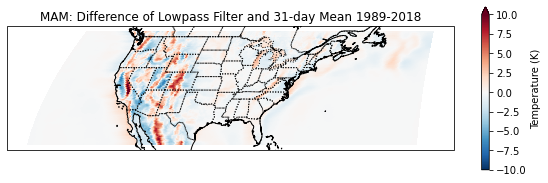

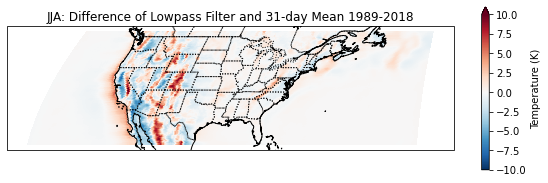

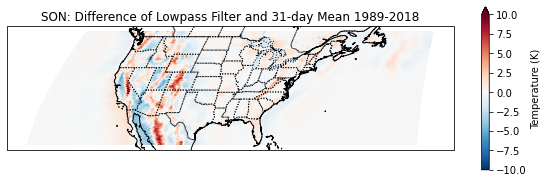

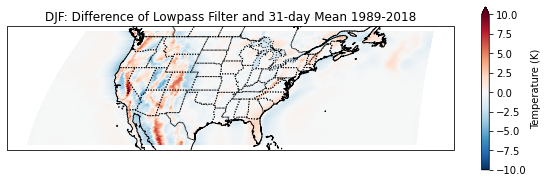

In [151]:
fig = plt.figure(figsize=(10, 3))
ax = plt.axes(projection=ccrs.Robinson())
cmap = cm.RdBu_r

MAM_diff_1989_2018.plot(
    ax=ax,
    cmap=cmap,
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": "Temperature (K)"}, vmin=-10.0, vmax=10.0)

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle=":")
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.set_title("MAM: Difference of Lowpass Filter and 31-day Mean 1989-2018")

fig = plt.figure(figsize=(10, 3))
ax = plt.axes(projection=ccrs.Robinson())
cmap = cm.RdBu_r

JJA_diff_1989_2018.plot(
    ax=ax,
    cmap=cmap,
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": "Temperature (K)"}, vmin=-10.0, vmax=10.0)

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle=":")
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.set_title("JJA: Difference of Lowpass Filter and 31-day Mean 1989-2018")

fig = plt.figure(figsize=(10, 3))
ax = plt.axes(projection=ccrs.Robinson())
cmap = cm.RdBu_r

SON_diff_1989_2018.plot(
    ax=ax,
    cmap=cmap,
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": "Temperature (K)"}, vmin=-10.0, vmax=10.0)

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle=":")
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.set_title("SON: Difference of Lowpass Filter and 31-day Mean 1989-2018")

fig = plt.figure(figsize=(10, 3))
ax = plt.axes(projection=ccrs.Robinson())
cmap = cm.RdBu_r

DJF_diff_1989_2018.plot(
    ax=ax,
    cmap=cmap,
    transform=ccrs.PlateCarree(),
    cbar_kwargs={"label": "Temperature (K)"}, vmin=-10.0, vmax=10.0)

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle=":")
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.set_title("DJF: Difference of Lowpass Filter and 31-day Mean 1989-2018")